# Long Short Term Memory

In [1]:
from whittaker_smooth import whittaker_smooth
from dataclasses import dataclass
from datetime import date

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import utils
import pickle
import tensorflow as tf

In [2]:
# TODO: Changes these values for parameters on a database.
BASE_DIR = '/home/aargaez/Downloads/Plant-Growth-Cycle-based-on-geospatial-data/DataExtraction/kansas'
bands =  ['B4','B3','B2','B8']

# Dictionaries of the images.
images_kansas19 = utils.load_landsat_image(BASE_DIR + '19', bands)
images_kansas20 = utils.load_landsat_image(BASE_DIR + '20', bands)
images_kansas21 = utils.load_landsat_image(BASE_DIR + '21', bands)
images_kansas22 = utils.load_landsat_image(BASE_DIR + '22', bands)

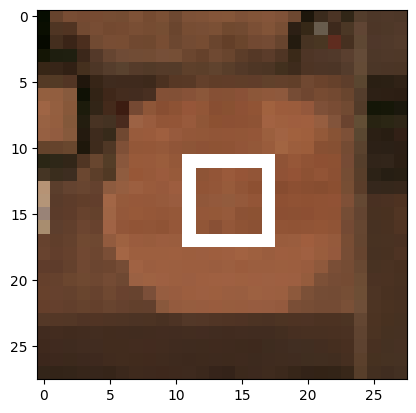

In [3]:
# Get the days after plant and the dates.
days_19, dates_19, hours_19 = utils.images_time_info(images_kansas19.keys(), initial_date = date(2019, 4, 5))
days_20, dates_20, hours_20 = utils.images_time_info(images_kansas20.keys(), initial_date = date(2020, 4, 4))
days_21, dates_21, hours_21 = utils.images_time_info(images_kansas21.keys(), initial_date = date(2021, 4, 2))
days_22, dates_22, hours_22 = utils.images_time_info(images_kansas22.keys(), initial_date = date(2022, 4, 2))

# Calculate the NDVI series over the crops.
ndvi_series_19 = utils.generate_ndvi_time_series(images_kansas19)
ndvi_series_20 = utils.generate_ndvi_time_series(images_kansas20)
ndvi_series_21 = utils.generate_ndvi_time_series(images_kansas21)
ndvi_series_22 = utils.generate_ndvi_time_series(images_kansas22)

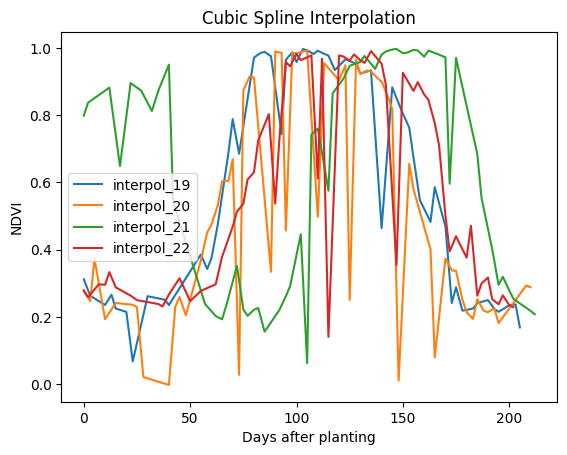

In [4]:
plt.plot(days_19, ndvi_series_19, label='interpol_19')
plt.plot(days_20, ndvi_series_20, label='interpol_20')
plt.plot(days_21, ndvi_series_21, label='interpol_21')
plt.plot(days_22, ndvi_series_22, label='interpol_22')
plt.title('Cubic Spline Interpolation')
plt.xlabel('Days after planting')
plt.ylabel('NDVI')
plt.legend()
plt.show()

In [5]:
# Apply a Whittaker Smooth filter.
ndvi_smooth_19 = whittaker_smooth(np.array(ndvi_series_19), lmbd=10)
ndvi_smooth_20 = whittaker_smooth(np.array(ndvi_series_20), lmbd=10)
ndvi_smooth_21 = whittaker_smooth(np.array(ndvi_series_21), lmbd=10)
ndvi_smooth_22 = whittaker_smooth(np.array(ndvi_series_22), lmbd=10)

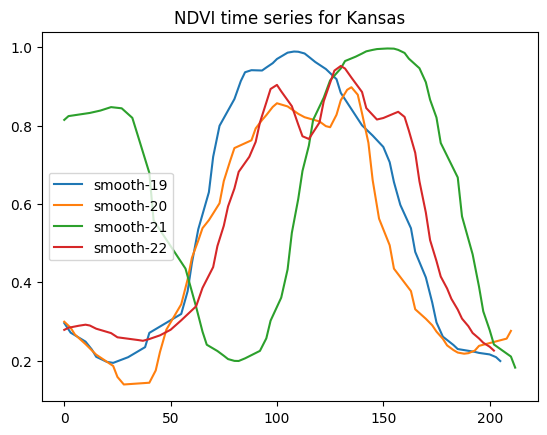

In [6]:
plt.title('NDVI time series for Kansas')
plt.plot(days_19, ndvi_smooth_19, label='smooth-19')
plt.plot(days_20, ndvi_smooth_20, label='smooth-20')
plt.plot(days_21, ndvi_smooth_21, label='smooth-21')
plt.plot(days_22, ndvi_smooth_22, label='smooth-22')
plt.legend()
plt.show()

In [7]:
# Apply an interpolation by splines.
x_19, y_19 = utils.interpolate_curve(days_19, ndvi_smooth_19)
x_20, y_20 = utils.interpolate_curve(days_20, ndvi_smooth_20)
x_21, y_21 = utils.interpolate_curve(days_21, ndvi_smooth_21)
x_22, y_22 = utils.interpolate_curve(days_22, ndvi_smooth_22)

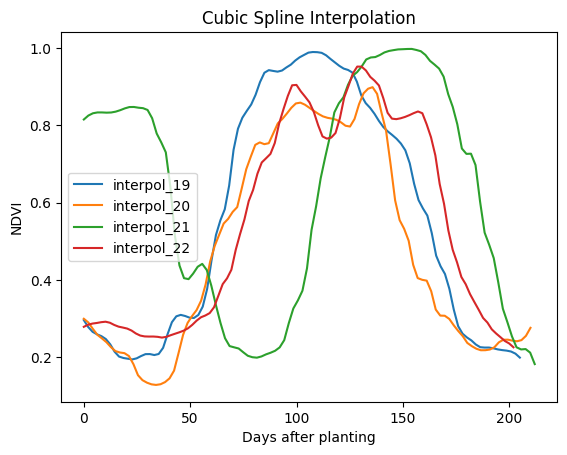

In [8]:
plt.plot(x_19, y_19, label='interpol_19')
plt.plot(x_20, y_20, label='interpol_20')
plt.plot(x_21, y_21, label='interpol_21')
plt.plot(x_22, y_22, label='interpol_22')
plt.title('Cubic Spline Interpolation')
plt.xlabel('Days after planting')
plt.ylabel('NDVI')
plt.legend()
plt.show()

In [9]:
x = np.concatenate((x_19, x_20, x_22), axis=0)
y = np.concatenate((y_19, y_20, y_22), axis=0)
# Generate the time-window in days after planting.
time = [i for i in range(len(y))]

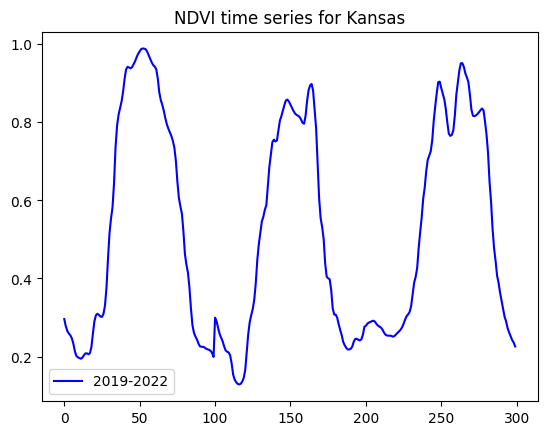

In [10]:
plt.title('NDVI time series for Kansas')
plt.plot(time, y, 'b', label='2019-2022')
plt.legend()
plt.show()

In [ ]:
# Let's save the parameters of our time series in the dataclass
@dataclass
class G:
  TIME, SERIES = time, y
  # Number of days to be used on the training set.
  # The rest will belong to the validation set
  SPLIT_TIME = 200
  # How many data points will we take into account to make our prediction
  WINDOW_SIZE = 25
  # How many items will we supply per batch
  BATCH_SIZE = 32
  # Define the Tensorflow sample buffer
  SHUFFLE_BUFFER_SIZE = 1000

In [ ]:
def train_val_split(
    time,
    series,
    time_step=G.SPLIT_TIME
  ):
  """
  Divide the time series into training and validation set.
  """
  time_train = time[:time_step]
  series_train = series[:time_step]
  time_valid = time[time_step:]
  series_valid = series[time_step:]
  
  return time_train, series_train, time_valid, series_valid